# Adding noise to the EAGLE simulations
This goal of this notebook is to explore adding noise to the EAGLE simulation to make mock observations.  The main part of this notebook doesn't even use the simulations, it just explores the sources of noise as added to a pretend data set (a circle on a blank background).

We will go through the different types of noise so that it is clear which one dominates the signal.  In particular, we want to explore when read out noise trades out with the sky background as the dominant noise source.

### Sources of Poisson noise:
The shot noise, dark current noise, and sky background noise are all Poisson processes.  Therefore can draw from a Poisson or Gaussian (large number statistics) distribution with a sigma that is the square root of the mean value for each background source to draw random values for the noise.

> For small photon counts, photon noise is generally dominated by other signal-independent sources of noise, and
for larger counts, the central limit theorem ensures that the Poisson distribution approaches a Gaussian.

> The ratio of signal to photon noise grows with the square root
of the number of photons captured, √ λt. <br>
( https://people.csail.mit.edu/hasinoff/pubs/hasinoff-photon-2012-preprint.pdf )

Poission_noise = sigma = SQRT(meanvalue_Poisson)

e.g. D_noise = SQRT ( D )

### Read out noise:
The read out noise is a Gaussian process, therefore can draw from a Gaussian distribution with a sigma that is the read out noise value given.  

> CCD manufacturers measure and report CCD noise as a number of electrons RMS (Root Mean Square).  You’ll typically see it presented like this, 15eˉ RMS, meaning that with this CCD, you should expect to see about 15 electrons of noise per pixel.  More precisely, 15eˉ RMS is the standard deviation around the mean pixel value. <br>
( http://www.qsimaging.com/ccd_noise.html )

It seems that we don't actually know the mean value of the read out noise, so we should center the read out noise at zero (since we can subtract the mean value off in the images).

Gaussian_noise = sigma = R

### Combining noise:
We then add the noise in quadrature (error propagation):

Noise_total = SQRT ( Poisson_noise ^ 2 + Gaussian_noise ^2 + ... ) = SQRT ( (meanvalue_Poisson) + R^2 + ...)

For a couple references on error propagation, check out:
http://www.mso.anu.edu.au/pfrancis/ObsTech/Stats2.pdf and https://www.deanza.edu/faculty/marshburnthomas/pdf/ErrorPropagation.pdf.


In [1]:
import numpy as np
import eagle_constants_and_units as c
import cosmo_utils as csu
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import mpl_toolkits.axes_grid1 as axgrid
from astropy import constants as const
from astropy import units as u

import get_halpha_SB

%matplotlib inline

In [2]:
%run 'load_data.ipynb'

First, let's declare some variables from the Dragonfly Telephoto array.

We will also declare a background value, which was taken from the Gemini Sky Background spectrum.  
*Verify that this background is correct*

In [3]:
# Dragonfly info
area_lens = np.pi*(14.3/2)**2 * 48. *10.                # cm^2, 48 * 14.3 cm diameter lenses
pix_size = 2.8                                          # arcsec
ang_size_pixel  = (pix_size * (1./206265.))**2          # rad^2, the pixel size of the CCD
tau_l = 0.85                                            # transmittance of the Dragonfly lens
tau_f = 1.                                              # transmittance of the Halpha filter -- assumed for now
#B = getBackground(656.3,657.3,machine)                  # *u.photon/u.second/u.arcsec**2/u.m**2  ****already multiplied by the bandwidth***
B = 0.560633
D = 0.04       # dark current (electrons / s) 
QE=0.48 # current cameras

In [4]:
debugging = True

Adding the sky background (and the Poisson noise background from the data as well, in one go).

1. Grab sky background 
2. Multiply sky background by efficiency factors, by the aperture area, and the by square angular pixel size
3. Multiply sky background by the exposure time
4. Multiply sky background by the number of pixels in one bin
5. Make an array the shape of the data, to put the sky background and Poisson noise into
6. Draw from a random gaussian distribution of the sqrt of the background (and the data) for each element of the array
7. Return the array of sky background and Poisson noise, and the value of the sky background for a binned pixel in the exposure time

In [5]:
def add_skybackground(detsignal,numpixel):
    'Background from stuff in space'
    'background sky signal detected [B]=ph/s/arcsec^2/m^2, [B_sky]=ph/s (in a pixel)'
    B_sky = B * QE * tau_l * tau_f * area_lens*(1/100.)**2 * pix_size**2
    if debugging:
        print "DEBUGGING: the background in the bandwidth is: %s"%B
        print "DEBUGGING: the background signal, B_sky [ph/s (in a pixel)], is: %s"%B_sky
    B_sky_inexptime = B_sky*exptime
    B_sky_total     = B_sky_inexptime*numpixel    
    B_sky_array = np.zeros((data.shape[0],data.shape[1]))
    for x in range(data.shape[0]):
        for y in range(data.shape[1]):
            B_sky_array[x][y]=np.random.normal(0,np.sqrt(B_sky_total+detsignal[x][y])) 
#            B_sky_array[x][y]=np.random.poisson(B_sky_total)
#    B_sky_array_total = B_sky_array
    if debugging:
        print "DEBUGGING: the mean total background signal, B_sky_total [electrons], is: %s"\
                %B_sky_total
        print "DEBUGGING: the total background noisy signal [electrons] ranges from: %s to %s"\
                %(np.min(B_sky_array),np.max(B_sky_array))
 
    return B_sky_total, B_sky_array

Adding the dark current. 

In [12]:
def add_darkcurrent(numpixel):
    'DarkCurrent'
    noise_from_detector = 0.0
    D_total = D*exptime*numpixel
    D_array_total = np.zeros((data.shape[0],data.shape[1]))
    for x in range(data.shape[0]):
        for y in range(data.shape[1]):
            D_array_total[x][y]=np.random.normal(D_total,np.sqrt(D_total)) 
    if debugging:
        print "DEBUGGING: the total dark current [electrons] is: %s"%(D_total)
        print "DEBUGGING: the total dark current noisy signal [electrons] ranges from: %s to %s"\
                %(np.min(D_array_total),np.max(D_array_total))
        
    return D_array_total

Adding the read out noise.  *Note to self: I don't know why the sigma was B_sky for the read out noise in the previous script... i'm guessing for testing but it is very confusing to me*

1. If the number of exposures is not provided, assume the exposures are an hour long, so get the number of times data read out by dividing exposure time by 3600 secounds
2. The read out noise is Gaussian distributed with sigma R (10e- for Dragonfly) so return a random value draw from a Gaussian distribution with sigma R

This algorithm for applying the readout noise assumes that each 2.8 arcsecond pixel (i.e. inherent Dragonfly pixel, not binned) is assigned a (random) readout noise.  

Since we will end up binning the data over some number of pixels, "numpixel", we build an array the size of the binned array (smaller than the inherent Dragonfly array), and in each index of the array, we store the SUM of the readout noise from each of the pixels and from each exposure.  We store the SUM instead of the AVERAGE because we won't be able to calculate the average readout noise independantly in the actual data (unless we do on-chip binning).  (So, right now I am assuming off-chip binning).

The binned read out noise is stored in "R_array".

The squared of "R_array" is stored in "R_squared_array", in prep for adding the noise in quadrature.  *Note to self:  Wait, why am I doing this?*



In [10]:
def add_readoutnoise(R_squared,numpixel,expnum):
    'ReadOut Noise'
    numexp = 1
    R = np.sqrt(R_squared)
    if expnum is None:
        numexp = exptime/3600. # hour long exposures
        print "DEBUGGING: No expnum provided, assuming hour long exposures."
    else:
        numexp = expnum
    print "DEBUGGING: The number of exposures is: %s" % numexp
    
    R_squared_array = np.zeros((data.shape[0],data.shape[1]))
    R_array = np.zeros((data.shape[0],data.shape[1]))
    for x in range(data.shape[0]):
        for y in range(data.shape[1]):
#### OLD
####            R_squared_array[x][y]=np.mean(np.random.normal(np.sqrt(R_squared),np.sqrt(np.sqrt(B_sky)),int(numpixel)))**2   
            R_squared_array[x][y]=(np.sum(np.random.normal(0,R,int(numpixel)*round(numexp))))**2 # centered at 0, st dev of R, return numpixel*numexp values
            R_array[x][y]=np.sum(np.random.normal(0,R,int(numpixel)*round(numexp)))
####    R_squared_total_array = R_squared_array
####    R_squared_total = R_squared
    if debugging:
        print "DEBUGGING: Standard deviation of R array: %s " % np.std(R_array)
        print "DEBUGGING: the R_squared value is: %s, so in %s exposures [per pixel], will have R_squared of: %s"\
                %(R_squared,numexp,R_squared * round(numexp))
        print "DEBUGGING: the total R_squared value [electrons] multiplying by numpix read out is: %s"\
                %((R_squared * round(numexp) * numpixel))
        print "DEBUGGING: the max and min R_squared values are: %s and %s" \
                %(np.max(R_squared_array),np.min(R_squared_array))
        print "DEBUGGING: the max and min R values are: %s and %s" \
                %(np.max(R_array),np.min(R_array))
        
    return R_squared_array, R_array

In [46]:
def addnoise(data,resolution,log = True,R_squared=None,expnum=None, exptime=10**3*3600.,CMOS=False, debugging=True):
    """
    This function adds noise to simulated data (such as the EAGLE simulation) to create mock observations.
    The EAGLE data is logged though, so the log = True for the EAGLE stuff
    """
    binpix_size = resolution # arcsec
    numpixel = round((binpix_size/pix_size)**2)
    if CMOS:
        print "VERBOSE: Using new CMOS cameras..."
        QE = 0.70                                           # quantum efficiency of the CMOS detector
    else:
        print "VERBOSE: Using old cameras..."
        QE = 0.48    
    
    if R_squared is None:
        if CMOS:
            R_squared = 2.**2                               # read noise (electrons)
        else:
            R_squared = 10.**2                              
    
    if debugging:
        print "DEBUGGING: R_squared is : %s" % R_squared
        print "DEBUGGING: the number of pixels is %s" % numpixel
    
    if log:
        if debugging:
            print "DEBUGGING: raise the data by 10** since was logged data before..."
        data = 10**data
    
    'total signal incident in exposure time'
    totsignal = data * exptime # ( photons / cm^2 /sr )
    'total signal detected (accounting for system efficiency)'
    detsignal = totsignal * QE * tau_l * tau_f * area_lens * ang_size_pixel * numpixel
    
    if debugging:
        print "DEBUGGING: the total object signal [electrons] detected ranges from: %s to %s"%(np.min(detsignal),np.max(detsignal))
        #print "DEBUGGING: an example of the object signal [electrons] is: %s"%detsignal[0]
    
    print "Adding sky background noise and shot noise."
    B_sky_total, B_sky_array = add_skybackground(detsignal,numpixel)
    noiseadded_signal = detsignal + B_sky_total + B_sky_array
    
    print "Adding read out noise to the signal."
    R_squared_array, R_array = add_readoutnoise(R_squared,numpixel,expnum)
    noise_from_detector = R_squared_array*numpixel

    print "Adding dark current to the signal."
    D_array_total = add_darkcurrent(numpixel)
    noise_from_detector = noise_from_detector + D_array_total
    
    #if debugging:
    #    print "DEBUGGING: an example total noise (not squarerooted) is: %s"%(detsignal + B_sky_array + D_array_total + R_squared_total_array*numpixel)[0]
    
    noiseadded_signal = noiseadded_signal + noise_from_detector
    
    return noiseadded_signal,B_sky_array,R_array

To demonstrate the dependence of the different noise sources on time, I need a mock data set that I will add noise to.
How about not even using the EAGLE data at first, instead just using a circle of ones on a background of zeros (to make everything very clear!).

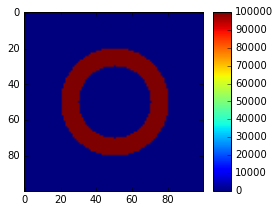

In [63]:
size = 100
pretenddata = np.zeros((size,size))
for j in np.arange(size)-size/2:
    for i in np.arange(size)-size/2:
        if np.sqrt(j**2 + i**2) < 30. and np.sqrt(j**2 + i**2) > 20. :  
            pretenddata[j+size/2,i+size/2] = 100000.
    
def plotdata(pretenddata,ax=None,bounds=None):
    oneplot=False
    if ax is None:
        fig = plt.figure(figsize=(6, 3.2))
        ax = fig.add_subplot(111)
        oneplot=True
        ax.set_title('Pretend Data')
    if bounds is None:
        img = ax.imshow(pretenddata)
    else:
        img = ax.imshow(pretenddata,vmin=bounds[0],vmax=bounds[1])
    #plt.imshow(pretenddata)
    ax.set_aspect('equal')
    div = axgrid.make_axes_locatable(ax)
    cax = div.append_axes("right",size="10%",pad=0.15)
    #cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
    #cax.get_xaxis().set_visible(False)
    #cax.get_yaxis().set_visible(False)
    #cax.patch.set_alpha(0)
    #cax.set_frame_on(False)
    #if fixscale:
    cbar = plt.colorbar(img,cax=cax,orientation='vertical')#,boundaries=np.linspace(0,90000))
    cbar.ax.tick_params()
    if oneplot:
        plt.show()

fig, (ax1) = plt.subplots(1, 1, figsize=(4, 4))
plotdata(pretenddata,ax=ax1)
plt.tight_layout()

The next step is to start adding noise i.e. integrate for a small amount of time.

The add_noise function takes a couple inputs along with the data:
1. resolution
2. exposure time
3. readout noise value (optional)
4. toggle to use CMOS detectors (optional)

Let's not use the CMOS detectors, and let's use the default read out noise for now.

Let's just say we are not binning at first, so the resolution is the same as the detector (2.8").

And finally, let's use various exposure times, starting with one minute (60 seconds) and going upwards by orders of magnitude from there.  Also added the 2000s exposure to compare with the read out noise, since that is when sky background noise catches up to readout noise (see plots below to illustrate this).

Let's just say there will be one exposure (expnum = 1), used to calculate the read out noise.  If we leave that empty, the addnoise function will assume hour long exposures.

In [70]:
data = pretenddata; resolution = 2.8; exptime = 60.
noiseadded_signal1,B_sky_array1,R_array1 = addnoise(data,resolution,log=False,exptime=exptime, expnum=1, debugging=True)
R_squared_array1 = R_array1**2

data = pretenddata; resolution = 2.8; exptime = 600.
noiseadded_signal2,B_sky_array2,R_array2 = addnoise(data,resolution,log=False,exptime=exptime, expnum=1, debugging=True)
R_squared_array2 = R_array2**2

data = pretenddata; resolution = 2.8; exptime = 2000.
noiseadded_signal22,B_sky_array22,R_array22 = addnoise(data,resolution,log=False,exptime=exptime, expnum=1, debugging=True)
R_squared_array22 = R_array22**2

data = pretenddata; resolution = 2.8; exptime = 6000.
noiseadded_signal3,B_sky_array3,R_array3 = addnoise(data,resolution,log=False,exptime=exptime, expnum=1, debugging=True)
R_squared_array3 = R_array3**2

VERBOSE: Using old cameras...
DEBUGGING: R_squared is : 100.0
DEBUGGING: the number of pixels is 1.0
DEBUGGING: the total object signal [electrons] detected ranges from: 0.0 to 34.7759968285
Adding sky background noise and shot noise.
Adding read out noise to the signal.
DEBUGGING: The number of exposures is: 1


/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Adding dark current to the signal.
VERBOSE: Using old cameras...
DEBUGGING: R_squared is : 100.0
DEBUGGING: the number of pixels is 1.0
DEBUGGING: the total object signal [electrons] detected ranges from: 0.0 to 347.759968285
Adding sky background noise and shot noise.
Adding read out noise to the signal.
DEBUGGING: The number of exposures is: 1
Adding dark current to the signal.
VERBOSE: Using old cameras...
DEBUGGING: R_squared is : 100.0
DEBUGGING: the number of pixels is 1.0
DEBUGGING: the total object signal [electrons] detected ranges from: 0.0 to 1159.19989428
Adding sky background noise and shot noise.
Adding read out noise to the signal.
DEBUGGING: The number of exposures is: 1
Adding dark current to the signal.
VERBOSE: Using old cameras...
DEBUGGING: R_squared is : 100.0
DEBUGGING: the number of pixels is 1.0
DEBUGGING: the total object signal [electrons] detected ranges from: 0.0 to 3477.59968285
Adding sky background noise and shot noise.
Adding read out noise to the signa

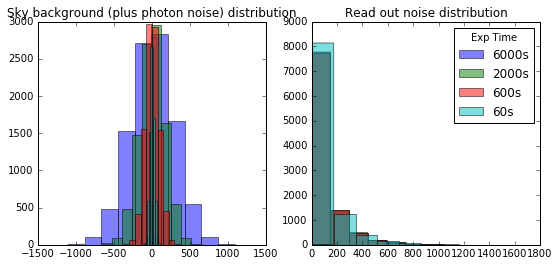

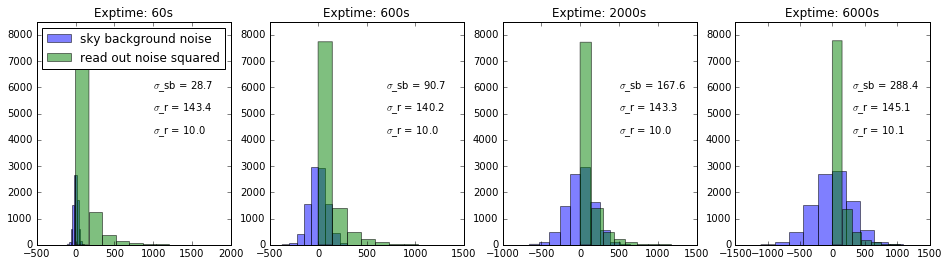

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
ax1.set_title('Sky background (plus photon noise) distribution')
for data in [B_sky_array3,B_sky_array22,B_sky_array2,B_sky_array1]:
    ax1.hist(np.ravel(data),edgecolor='black', alpha = 0.5)

#fig = plt.figure(figsize=(6, 3.2))
#ax = fig.add_subplot(111)
ax2.set_title('Read out noise distribution')
for data,label in zip([R_squared_array3,R_squared_array22,R_squared_array2,R_squared_array1],\
                      ['6000s','2000s','600s','60s']):
    ax2.hist(np.ravel(data),edgecolor='black', alpha = 0.5,label=label)
ax2.legend(title='Exp Time')

def plthist(ax3,B_sky,R_squared,R,title='',label1='',label2='',label3=''):
    ax3.hist(np.ravel(B_sky),edgecolor='black', alpha = 0.5,label=label1)
    ax3.hist(np.ravel(R_squared),edgecolor='black', alpha = 0.5,label=label2)
    #ax3.hist(np.ravel(R),edgecolor='black', alpha = 0.5, label=label3)
    ax3.legend()
    ax3.text(0.6,0.7,r'$\sigma$_sb = %.1f'%(np.std(B_sky)),transform=ax3.transAxes)
    ax3.text(0.6,0.6,r'$\sigma$_r = %.1f'%(np.std(R_squared)),transform=ax3.transAxes)
    ax3.text(0.6,0.5,r'$\sigma$_r = %.1f'%(np.std(R)),transform=ax3.transAxes)
    ax3.set_ylim(0,8500)
    ax3.set_title(title)
    
fig2, (ax3, ax4,ax44,ax5) = plt.subplots(1, 4, figsize=(16, 4))
plthist(ax3,B_sky_array1,R_squared_array1,R_array1,title='Exptime: 60s',\
        label1='sky background noise',label2='read out noise squared')#,label3='read out noise')
plthist(ax4,B_sky_array2,R_squared_array2,R_array2,title='Exptime: 600s')
plthist(ax44,B_sky_array22,R_squared_array22,R_array22,title='Exptime: 2000s')
plthist(ax5,B_sky_array3,R_squared_array3,R_array3,title='Exptime: 6000s')

plt.show()

From the plots above, one can see that the readout noise dominates until exposure time of ~30 minutes, when the sky background has grown to a similar level.  From that time onwards, the sky background continues growing.

Let's plot the noise added data to see what it looks like.

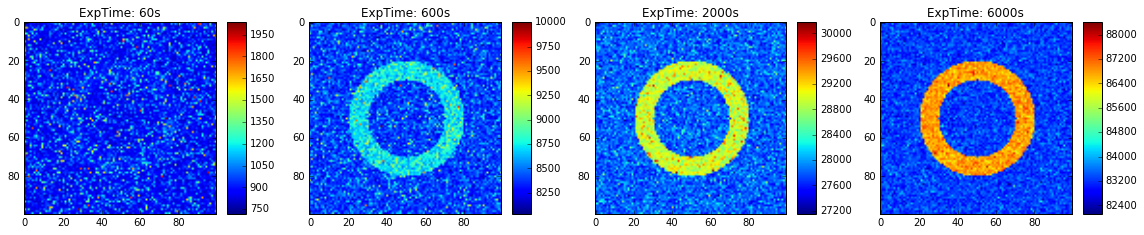

In [71]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 4))
plotdata(noiseadded_signal1,ax=ax1)
ax1.set_title('ExpTime: 60s')
plotdata(noiseadded_signal2,ax=ax2)
ax2.set_title('ExpTime: 600s')
plotdata(noiseadded_signal22,ax=ax3)
ax3.set_title('ExpTime: 2000s')
plotdata(noiseadded_signal3,ax=ax4)
ax4.set_title('ExpTime: 6000s')
plt.tight_layout()

VERBOSE: Using old cameras...
Adding sky background noise and shot noise.
Adding read out noise to the signal.
DEBUGGING: The number of exposures is: 1


/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Adding dark current to the signal.
VERBOSE: Using old cameras...
Adding sky background noise and shot noise.
Adding read out noise to the signal.
DEBUGGING: The number of exposures is: 1
Adding dark current to the signal.
VERBOSE: Using old cameras...
Adding sky background noise and shot noise.
Adding read out noise to the signal.
DEBUGGING: The number of exposures is: 1
Adding dark current to the signal.
VERBOSE: Using old cameras...
Adding sky background noise and shot noise.
Adding read out noise to the signal.
DEBUGGING: The number of exposures is: 1
Adding dark current to the signal.


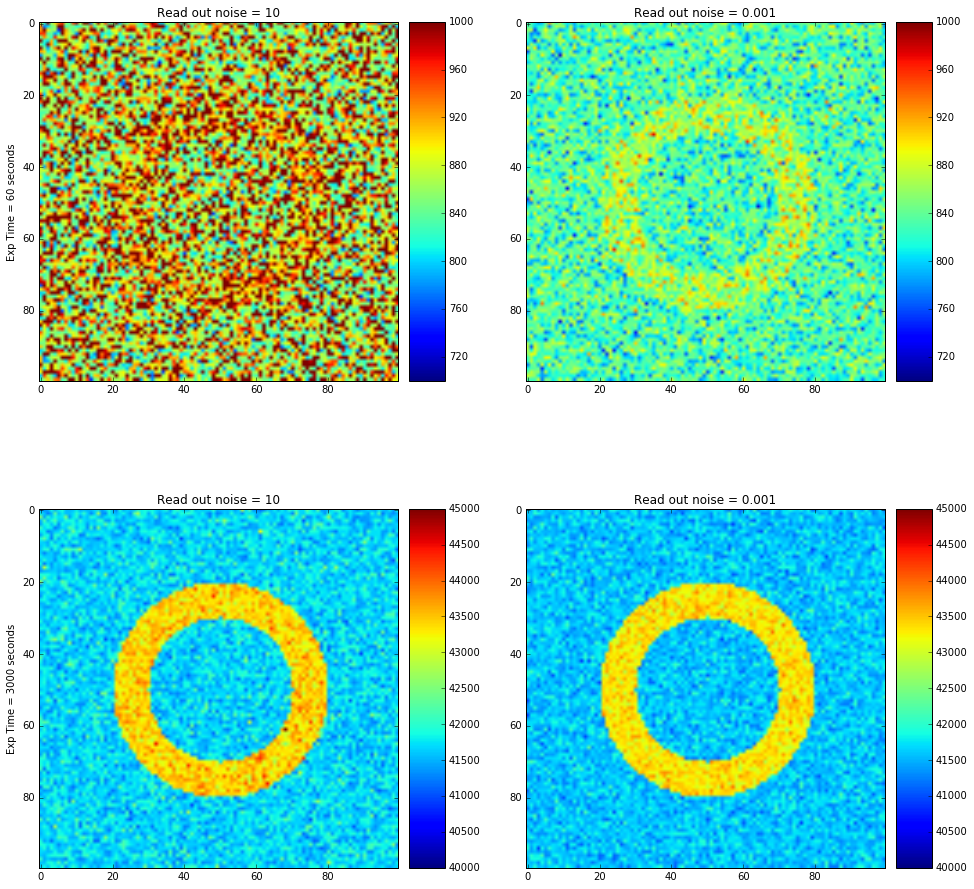

In [68]:
data = pretenddata; resolution = 2.8; exptime = 60.
noiseadded_signal1,B_sky_array1,R_array1 = addnoise(data,resolution,log=False,\
                                                    exptime=exptime, expnum=1, debugging=False)
R_squared_array1 = R_array1**2

noiseadded_signal2,B_sky_array2,R_array2 = addnoise(data,resolution,log=False,R_squared=0.001,\
                                                    exptime=exptime, expnum=1, debugging=False)
R_squared_array2 = R_array1**2

exptime = 3000.

noiseadded_signal3,B_sky_array3,R_array3 = addnoise(data,resolution,log=False,\
                                                    exptime=exptime, expnum=1, debugging=False)
R_squared_array3 = R_array3**2

noiseadded_signal4,B_sky_array4,R_array4 = addnoise(data,resolution,log=False,R_squared=0.001,\
                                                    exptime=exptime, expnum=1, debugging=False)
R_squared_array4 = R_array4**2

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 16))
plotdata(noiseadded_signal1,ax=ax1,bounds=[700,1000])
plotdata(noiseadded_signal2,ax=ax2,bounds=[700,1000])
plotdata(noiseadded_signal3,ax=ax3,bounds=[40000,45000])
plotdata(noiseadded_signal4,ax=ax4,bounds=[40000,45000])
ax1.set_title('Read out noise = 10')
ax1.set_ylabel('Exp Time = 60 seconds')
ax2.set_title('Read out noise = 0.001')
ax3.set_title('Read out noise = 10')
ax3.set_ylabel('Exp Time = 3000 seconds')
ax4.set_title('Read out noise = 0.001')

In [ ]:
# exposure time
exptime = 60.*60.*10**5  # seconds  (10^5 hours)
# where is the data
machine='coho'
# what distance and resolution do you want
distance = '50Mpc'; resolution = 100
data_tuple = loaddata(machine=machine,resolution=resolution,distance=distance)
# or do you want the raw data
data_tuple = loaddata(machine=machine)
data = data_tuple[0]